# FSRS vs. SuperMemo 18

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs-vs-sm18/blob/main/compare.ipynb)

In [1]:
%pip install -q FSRS-Optimizer==4.9.0
import fsrs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fsrs_optimizer import plot_brier
from sklearn.metrics import mean_squared_error

revlogs = pd.read_csv('revlog_history.tsv', sep='\t', keep_default_na=False)
revlogs = revlogs[(revlogs['i'] > 1) & (revlogs['delta_t'] > 0) & (revlogs['t_history'].str.count(',0') == 0)]

optimizer = fsrs_optimizer.Optimizer()

S0_dataset = revlogs[revlogs['i'] == 2]
optimizer.S0_dataset_group = S0_dataset.groupby(by=['r_history', 'delta_t'], group_keys=False).agg({'y': ['mean', 'count']}).reset_index()

optimizer.define_model()
optimizer.pretrain(verbose=False)

Note: you may need to restart the kernel to use updated packages.
Pretrain finished!


[]

In [2]:
optimizer.train(verbose=False)

  0%|          | 0/15993 [00:00<?, ?it/s]

Tensorized!
TRAIN: 11421 TEST: 4572
dataset built


train:   0%|          | 0/42710 [00:00<?, ?it/s]

TRAIN: 11805 TEST: 4188
dataset built


train:   0%|          | 0/42690 [00:00<?, ?it/s]

TRAIN: 13349 TEST: 2644
dataset built


train:   0%|          | 0/42680 [00:00<?, ?it/s]

TRAIN: 13545 TEST: 2448
dataset built


train:   0%|          | 0/42660 [00:00<?, ?it/s]

TRAIN: 13852 TEST: 2141
dataset built


train:   0%|          | 0/42640 [00:00<?, ?it/s]


Training finished!


[]

In [3]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")

Loss before training: 0.3262
Loss after training: 0.3223


R-squared: 0.5049
RMSE: 0.0472
MAE: 0.0282
[0.35406215 0.60734564]

Last rating: 1
R-squared: 0.0463
RMSE: 0.0832
MAE: 0.0534
[0.4046088  0.52260534]

Last rating: 2
R-squared: 0.3672
RMSE: 0.0825
MAE: 0.0548
[0.30102188 0.63894517]

Last rating: 3
R-squared: 0.4384
RMSE: 0.0566
MAE: 0.0294
[0.34868671 0.60397378]

Last rating: 4
R-squared: 0.1405
RMSE: 0.0496
MAE: 0.0224
[0.43299394 0.54009055]


({'R-squared': 0.5049363870756769,
  'RMSE': 0.04722154338314254,
  'MAE': 0.02824116337944002},
 (<Figure size 640x480 with 2 Axes>,
  <Figure size 1600x1200 with 8 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>))

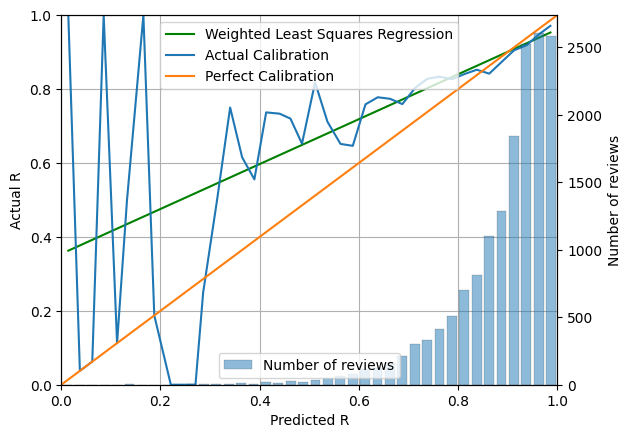

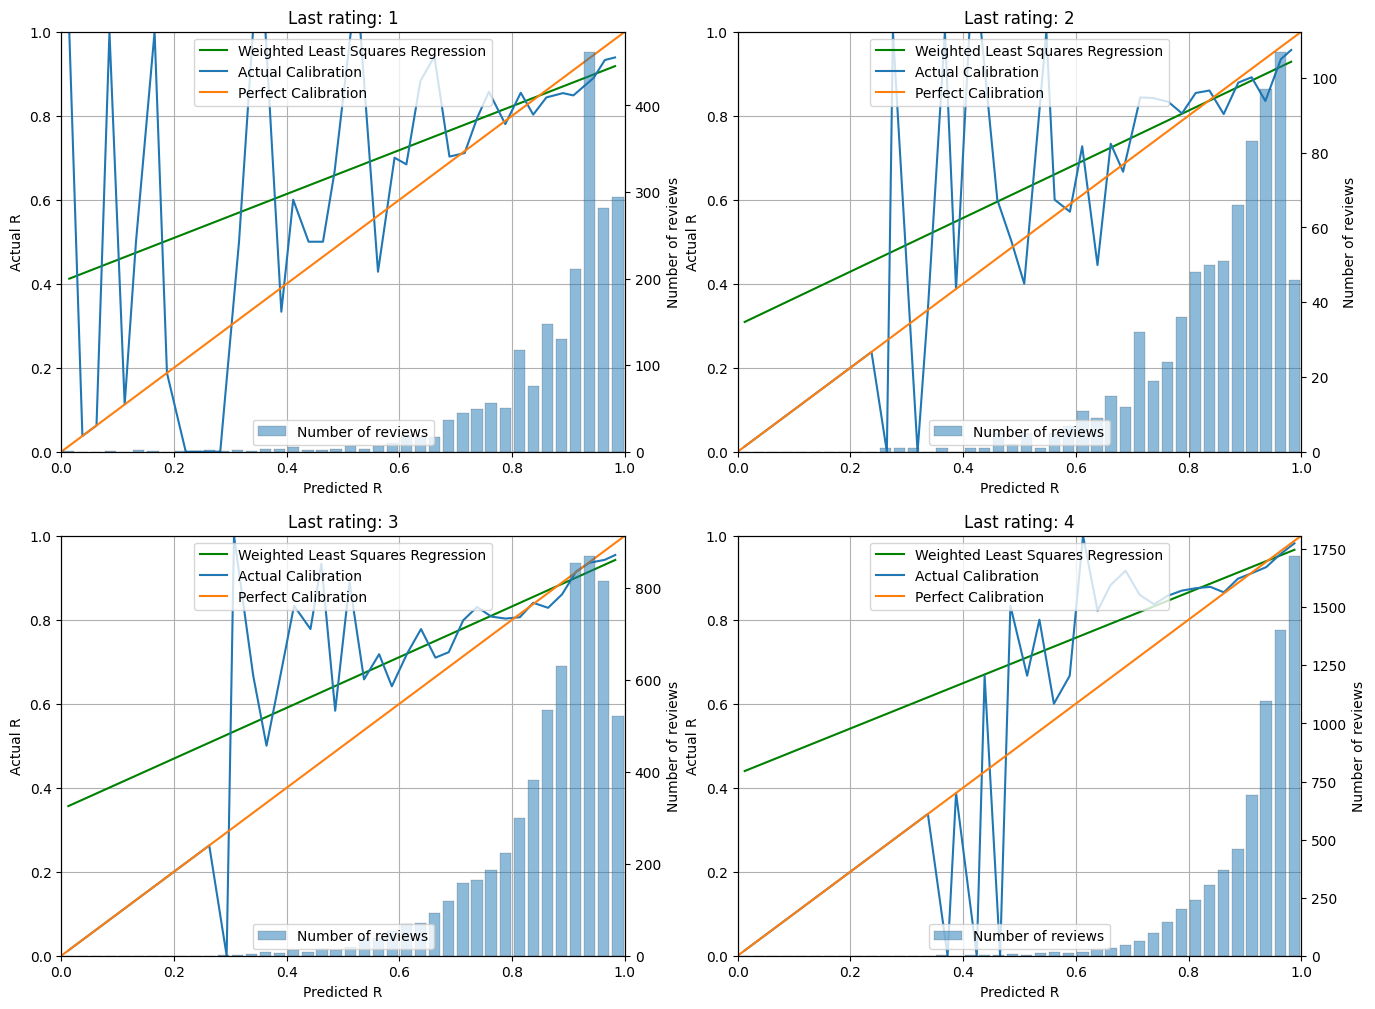

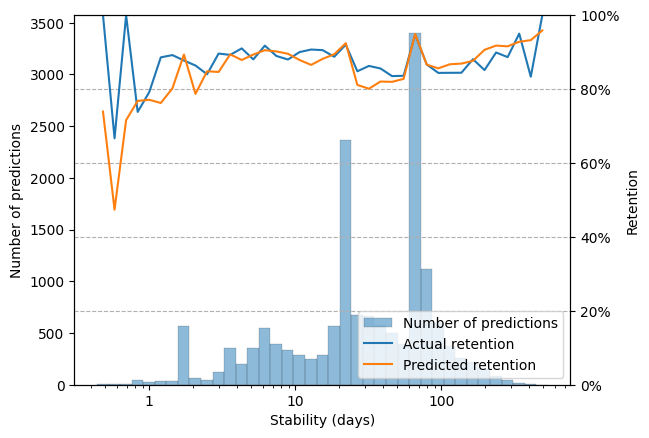

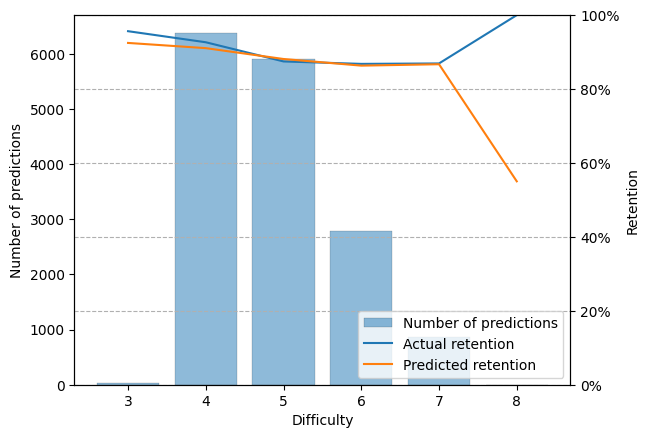

In [4]:
optimizer.calibration_graph()

Loss of SM-2: 1.3732
R-squared: -228.0327
RMSE: 0.5447
MAE: 0.4732
[0.85798508 0.08560569]
Universal Metric of FSRS: 0.0305
Universal Metric of SM2: 0.4813


(<Figure size 640x480 with 2 Axes>, <Figure size 600x600 with 1 Axes>)

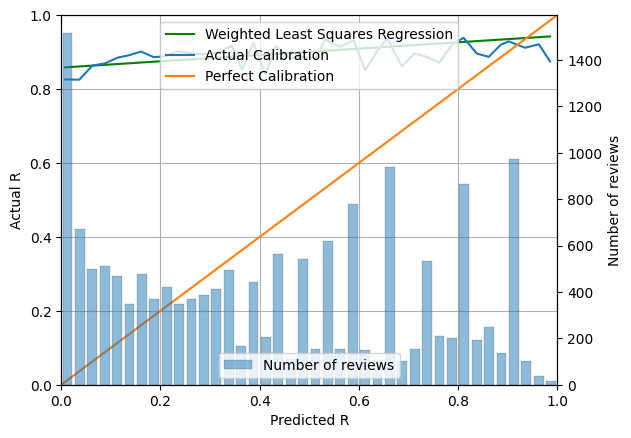

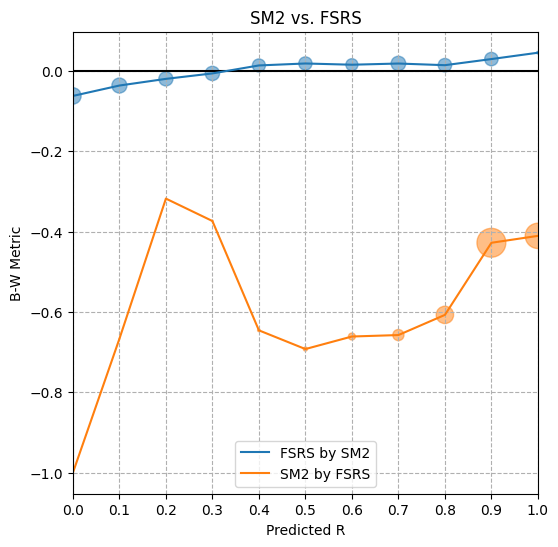

In [5]:
optimizer.compare_with_sm2()

Loss of SM-18: 0.3622
R-squared: -3.6270
RMSE: 0.1184
MAE: 0.0556
[0.64193665 0.29239881]
Universal Metric of FSRS: 0.0200
Universal Metric of SM18: 0.0438


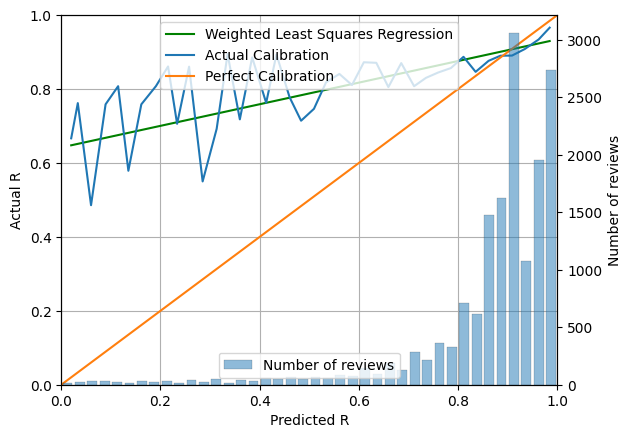

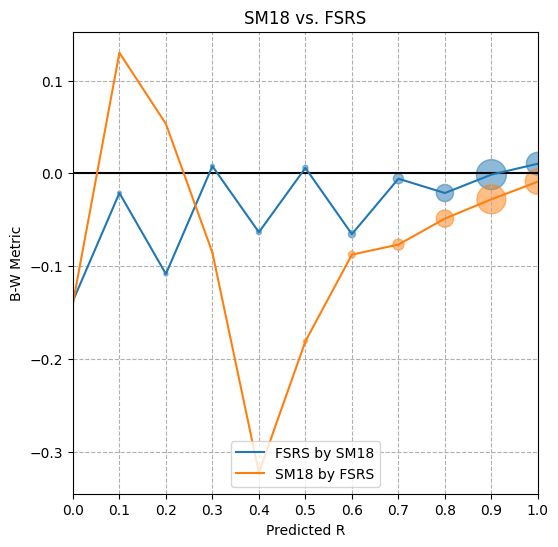

In [6]:
revlogs['p'] = optimizer.dataset['p']
revlogs['sm18_p'] = 1 - revlogs['expFI'] / 100
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['sm18_p']) if row['y'] == 1 else - np.log(1 - row['sm18_p']), axis=1)
print(f"Loss of SM-18: {revlogs['log_loss'].mean():.4f}")
cross_comparison = revlogs[['sm18_p', 'p', 'y']].copy()
fig1 = plt.figure()
plot_brier(cross_comparison['sm18_p'], cross_comparison['y'], bins=40, ax=fig1.add_subplot(111))
fig1.show()

fig2 = plt.figure(figsize=(6, 6))
ax = fig2.gca()

cross_comparison['SM18_B-W'] = cross_comparison['sm18_p'] - cross_comparison['y']
cross_comparison['SM18_Bin'] = cross_comparison['sm18_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM18_Bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
print(f"Universal Metric of FSRS: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False):.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['FSRS_B-W', 'mean'], label='FSRS by SM18')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM18_B-W': ['mean'], 'sm18_p': ['mean', 'count']})
print(f"Universal Metric of SM18: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm18_p', 'mean'], sample_weight=cross_comparison_group['sm18_p', 'count'], squared=False):.4f}")
cross_comparison_group['sm18_p', 'percent'] = cross_comparison_group['sm18_p', 'count'] / cross_comparison_group['sm18_p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['SM18_B-W', 'mean'], s=cross_comparison_group['sm18_p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['SM18_B-W', 'mean'], label='SM18 by FSRS')

ax.legend(loc='lower center')
ax.grid(linestyle='--')
ax.set_title("SM18 vs. FSRS")
ax.set_xlabel('Predicted R')
ax.set_ylabel('B-W Metric')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))

fig2.show()